## Table of Contents:
* [Dataset](#dataset)
* [Data Imputation](#data-imputation)
* [Feature Engineering](#feature-eng)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

Matplotlib created a temporary config/cache directory at /var/folders/y6/161nhsl11ys797vxqdv0p8m40000gq/T/matplotlib-4hh8qqkx because the default path (/Users/mw/.matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


## 1. Dataset <a class="anchor" id="dataset"></a>

In [2]:
train = pd.read_csv('/Users/mw/Desktop/AI/ML/kaggle/titanic/data/train.csv')

In [3]:
test_x = pd.read_csv('/Users/mw/Desktop/AI/ML/kaggle/titanic/data/test.csv')
test = pd.read_csv('/Users/mw/Desktop/AI/ML/kaggle/titanic/data/gender_submission.csv')

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
test_x.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [6]:
test.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [7]:
# get feature data types and check for missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [8]:
test_x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


<Axes: >

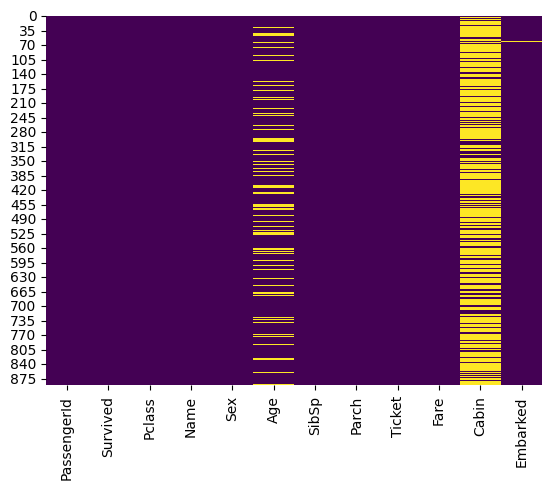

In [10]:
#visualize missing values using heatmap
sns.heatmap(train.isnull(),cbar=False,cmap='viridis')

## 2. Data Imputation <a class="anchor" id="data-inputation"></a>

#### 2.1 Cabin <a class="anchor" id="2.1"></a>

The Cabin feature represents the cabin number a passenger lived in. If the value is NaN then we know that the passanger did not have a assigned cabin. 

Since the current Cabin values and NaN are not numeric values, they need to be transformed. 

Seeing the amount of unique cabin values will let us know how to transform the data:

If there are few cabin values (something like less than 10) then we can assign some kind of numeric ordered value to each cabin value and then assign the non-cabin passengers a seperate numeric value. 

If there are much more unique cabin values then we can assume there is not much ordering/advantage between having specific cabins so we can tranform the feature to a binary value of has-cabin and doesnt.

In [11]:
print('Unique cabin values:', train['Cabin'].nunique())
print('First 10 unique cabin values:', train['Cabin'].unique().tolist()[:10])

Unique cabin values: 147
First 10 unique cabin values: [nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6', 'C23 C25 C27', 'B78']


Given that the number of unique cabin values are 147 it can be assumed that each unique cabin value will not provide much extra information on a passangers survival chances. 

The cabin numbers could be seperated into a couple categories based on the passangers mean price to see if we receive an increase in performance. If there is not much of an improvment then we can go with the standard binary transformation of 0=No cabin, 1=cabin.

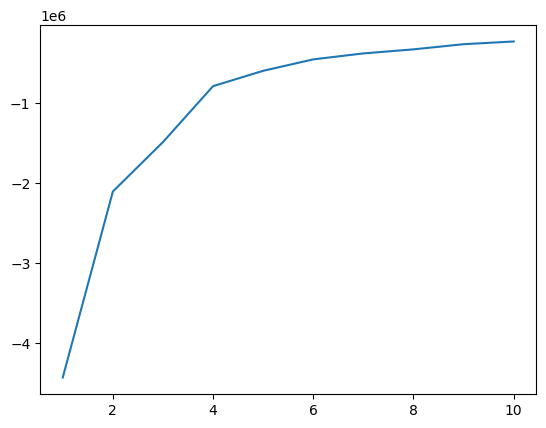

In [12]:
# seperate rows where cabin value has duplicate (like 'C23 C25 C27') seperate into duplicate rows but with each cabin value as one of the 3
# then convert cabin values to numeric (maybe A=100, B=200, etc..) then add on the numbers after the letter and plot a scatterplot

# X = [ [Cabin, Fare], [Cabin, Fare], etc.. ]
X = []
# done like this so we can play around with the letter transformations
char_transf = {'A': 100, 'B': 200, 'C': 300, 'D': 400, 'E': 500, 'F': 600, 'G':700, 'T': 800}

x = []
y = []

for cabin_val in train['Cabin'].unique():
    # check if cabin_val == NaN (as only NaN cant be compared to itself)
    if cabin_val != cabin_val:
        continue
        
        
    fare_sum = train.loc[train['Cabin']==cabin_val].Fare.sum()
    passenger_count = len(train[train['Cabin']==cabin_val])
    fare_mean = fare_sum / passenger_count
    
    multi_cabin = cabin_val.split(" ")
    if len(multi_cabin) > 1:
        for multi_cabin_val in multi_cabin:
            numeric_cabin = char_transf[multi_cabin_val[0]]
            if len(multi_cabin_val) > 1:
                numeric_cabin += int(multi_cabin_val[1:])
                
            X.append([numeric_cabin, fare_mean])
            x.append(numeric_cabin)
            y.append(fare_mean)
    else:
        numeric_cabin = char_transf[cabin_val[0]]
        if len(cabin_val) > 1:
            numeric_cabin += int(cabin_val[1:])
        X.append([numeric_cabin, fare_mean])
        x.append(numeric_cabin)
        y.append(fare_mean)
    
    #print(f'Cabin: {cabin_val}, Fare Mean: {fare_mean}, Passenger count: {passenger_count}')
    
#print(X)



# k_clusters = [ {'k': k, 'centers': center, 'labels': [labels] } ]
k_clusters = []
k_scores = []
# attempting k values 1-10 and returning optimal cluster count    
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto").fit(X)
    k_clusters.append(kmeans)
    kscore = kmeans.score(X)
    k_scores.append(kscore)
    
plt.plot([k for k in range(1, 11)], k_scores)
plt.show()

    
#train['Cabin'] = train['Cabin'].where(train['Cabin'].isnull(), 1).fillna(0).astype(int)

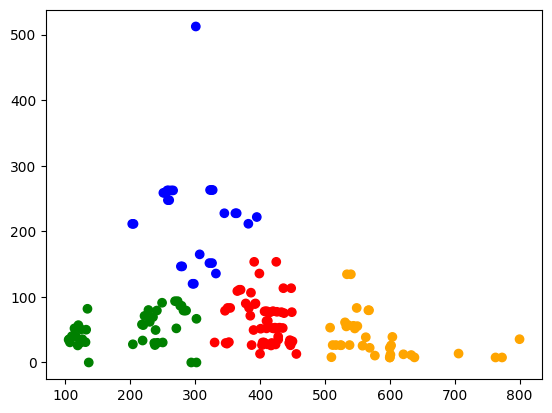

In [13]:
k = 4
colors = ['red', 'green', 'blue', 'orange']

sel_kmeans = k_clusters[k-1] #k-1 since 0 indexed
colors_list = [colors[i] for i in sel_kmeans.labels_]

    
plt.scatter(x, y, c=colors_list)
plt.show()

Now we check if there is any significant difference in survival rate between the 4 clusters

In [14]:
#for each point assign 1 to whichever cluster center its closest to and set the rest to zero


for ki in range(k):
    cluster_feature = [0]*len(train)
    train[f'Cabin Cluster {ki}'] = cluster_feature
    
train.head()

for i in train.index:
    row = train.iloc[i]
      
    cabin = row['Cabin']
    
    #only add prediction when not NaN
    if cabin == cabin:
        # get first val just in case multi cabin value
        cabin_split = cabin.split(" ")[0]
    
        fare_sum = train.loc[train['Cabin']==cabin].Fare.sum()
        passenger_count = len(train[train['Cabin']==cabin])
        fare_mean = fare_sum / passenger_count

        numeric_cabin = char_transf[cabin_split[0]]
        if len(cabin_split) > 1:
            numeric_cabin += int(cabin_split[1:])
            
        pred = sel_kmeans.predict([[numeric_cabin, fare_mean]])[0]
        train.at[i, f'Cabin Cluster {pred}'] = 1
        

        
            
        
        
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin Cluster 0,Cabin Cluster 1,Cabin Cluster 2,Cabin Cluster 3
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0,0,0


Now we have 4 extra features that represent the cluster group each cabin value belongs to.

Plotting the survival and non-survival count for each cabin cluster will let us know if there is any different impact on survival rate based on which cabin cluster you belong to. If there is a significant difference in survival then we know that the cabin clusters will provide us with extra useful information when deciding wether a passanger survived.

In [15]:
def surv_ratio_graph(df, features, feature_filters, use_filt, xlabel):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
    bar_width = 0.3
    surv_labels = {"Survived" : "Survived", "Didnt Survive" : "Didnt Survive"}

    survived_ratios = []
    
    for i in range(len(features)):
        feature = features[i]
        filter_val = feature_filters[i]
        survived = (train[train[feature]==filter_val]['Survived']==1).sum()
        didnt_survive = (train[train[feature]==filter_val]['Survived']==0).sum()
        surv_ratio = survived / (survived + didnt_survive)
        survived_ratios.append(surv_ratio)

        bar_surv = ax[0].bar(i, survived, bar_width, label=surv_labels['Survived'], color = "blue")
        bar_nosurv = ax[0].bar(i+bar_width, didnt_survive, bar_width, label=surv_labels['Didnt Survive'], color="grey")
        surv_labels['Survived'] = "_nolegend_"
        surv_labels['Didnt Survive'] = "_nolegend_"
                          
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel('Count')
    ax[0].legend(loc='best')
    ax[0].margins(x=0, y=0.1)
    
    ratio_x = features
    if use_filt:
        ratio_x = feature_filters

    ax[1].plot(ratio_x, survived_ratios)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('% Survived')
    ax[1].margins(x=0, y=0.1)

    plt.show()

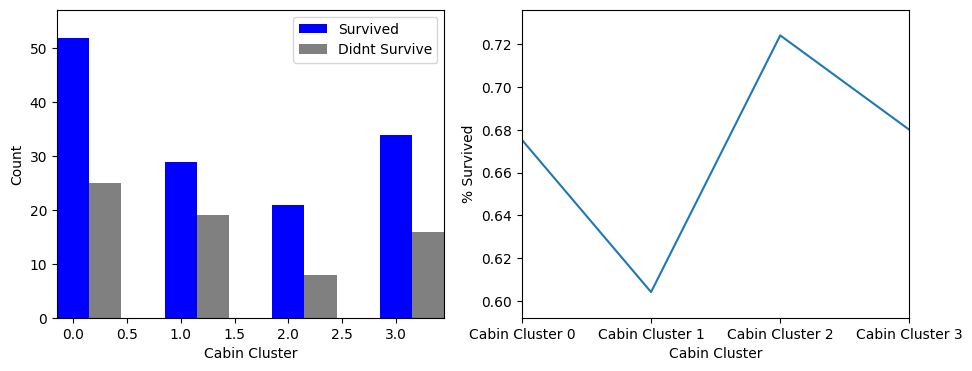

In [16]:
features = [f'Cabin Cluster {i}' for i in range(k)]
feature_filters = [1]*k
use_filt = False
surv_ratio_graph(train, features, feature_filters, use_filt, 'Cabin Cluster')

The % difference between clusters doesnt appear to be much. But since the sample size isnt that large we can perform a chi square test to see if the difference is just by random chance or due to an actual difference in clusters.

H0: Cabin Clusters are independent of survival 

H1: Reject independency

Ts = total passengers survived

Tcc0 = total passengers in cabin cluster zero

TT = total passengers in cabin cluster 0, 1, 2, and 3

(Tcc0 / TT) = % of passengers in Tcc0

Observed_CC0_Surv = (Ts) * (Tcc0 / TT)

If we take the total amount of survived passengers and multiply it by the % of passengers that are in cluster zero then we are saying that the % of survived passengers in cluster zero out of all the survived passengers should be the same as the % of passengers that are in cluster zero. Doing this for each cluster creates the expected survival count for each cluster distributing it evenly across each cluster. This creates the expected observation that there should be no difference in survival rate between the different clusters.

In [17]:
def getChiSq(exp, obs):
    return ((obs - exp)**2)/exp

In [18]:
Tcc = []
Tcc_surv = []
Tcc_no_surv = []
for i in range(k):
    cci = len(train[train[f'Cabin Cluster {i}'] == 1])
    cci_surv = len(train[(train[f'Cabin Cluster {i}']==1) & (train['Survived']==1)])
    cci_no_surv = len(train[(train[f'Cabin Cluster {i}']==1) & (train['Survived']==0)])
    Tcc.append(cci)
    
    Tcc_surv.append(cci_surv)
    Tcc_no_surv.append(cci_no_surv)
  
TT = sum(Tcc)
Ts = sum(Tcc_surv)
Tns = sum(Tcc_no_surv)

expected_surv_vals = []
expected_nosurv_vals = []
chi_sq = 0
for i in range(k):
    exp_s_i = Ts * (Tcc[i]/TT)
    obsv_s_i = Tcc_surv[i]
    exp_n_i = Tns * (Tcc[i]/TT)
    obsv_n_i= Tcc_no_surv[i]
    chi_sq += getChiSq(exp_s_i, obsv_s_i) #((obsv_s_i - exp_s_i)**2)/exp_s_i
    chi_sq += getChiSq(exp_n_i, obsv_n_i) #((obsv_n_i - exp_n_i)**2)/exp_n_i
    expected_surv_vals.append(exp_s_i)
    expected_nosurv_vals.append(exp_n_i)
    

print('observed survived', Tcc_surv)
print('expected survived', expected_surv_vals)
print('observed didnt survive', Tcc_no_surv)
print('expected didnt survive', expected_nosurv_vals)
print('chi square:', chi_sq)

observed survived [52, 29, 21, 34]
expected survived [51.33333333333333, 32.0, 19.333333333333332, 33.33333333333333]
observed didnt survive [25, 19, 8, 16]
expected didnt survive [25.666666666666664, 16.0, 9.666666666666666, 16.666666666666664]
chi square: 1.3407585087326466


Given our low chi square value we cannot succesffuly reject the null hypothesis. Therefore we conclude that the cabin clusters have no different impact on survival rate. We can now drop the cabin cluster columns and re-assign our cabin column to a binary relationship of 1-cabin, 0-nocabin

In [19]:
#Remove Cabin cluster features
cabin_clusters = [f'Cabin Cluster {i}'for i in range(k)]
train = train.drop(cabin_clusters, axis=1)
#Transform cabin column to binary
train['Cabin'] = train['Cabin'].where(train['Cabin'].isnull(), 1).fillna(0).astype(int)

In [20]:
Total_surv = len(train[train['Survived']==1])
Total_nosurv = len(train[train['Survived']==0])
Total_cabin = len(train[train['Cabin']==1])#len(train[~train['Cabin'].isna()])
Total_nocabin = len(train[train['Cabin']==0])#len(train[train['Cabin'].isna()])


TT = Total_surv + Total_nosurv


expected_cabin_surv = Total_cabin * (Total_surv/TT)
observed_cabin_surv = len(train[(train['Cabin']==1) & (train['Survived']==1)])

expected_cabin_nosurv = Total_cabin * (Total_nosurv/TT)
observed_cabin_nosurv = len(train[(train['Cabin']==1) & (train['Survived']==0)])


expected_nocabin_surv = Total_nocabin * (Total_surv/TT)
observed_nocabin_surv = len(train[(train['Cabin']==0) & (train['Survived']==1)])

expected_nocabin_nosurv = Total_nocabin * (Total_nosurv/TT)
observed_nocabin_nosurv = len(train[(train['Cabin']==0) & (train['Survived']==0)])



chi_sq = getChiSq(expected_cabin_surv, observed_cabin_surv) 
chi_sq += getChiSq(expected_cabin_nosurv, observed_cabin_nosurv)
chi_sq += getChiSq(expected_nocabin_surv, observed_nocabin_surv) 
chi_sq += getChiSq(expected_nocabin_nosurv, observed_nocabin_nosurv)


print('exp cabin surv', expected_cabin_surv)
print('obv cabin surv', observed_cabin_surv)

print('exp cabin no surv', expected_cabin_nosurv)
print('obv cabin no surv', observed_cabin_nosurv)

print('exp no cabin surv', expected_nocabin_surv)
print('obv no cabin surv', observed_nocabin_surv)

print('exp no cabin no surv', expected_nocabin_nosurv)
print('obv no cabin no surv', observed_nocabin_nosurv)

print('\n Chi Sq:', chi_sq)

exp cabin surv 78.3030303030303
obv cabin surv 136
exp cabin no surv 125.69696969696969
obv cabin no surv 68
exp no cabin surv 263.6969696969697
obv no cabin surv 206
exp no cabin no surv 423.30303030303025
obv no cabin no surv 481

 Chi Sq: 89.48572591188761


Given the high chi sq value, we can successfully reject the null hypothesis that there is no difference between those that do and dont have a cabin in survival rate. 

#### 2.2 Embarked <a class="anchor" id="2.2"></a>

From the heatmap we see that Embarked has very few missing values. Given this observation, the simplest approach is to remove the few rows where Embarked is null. 

However, since the training set is not that large to begin with we would like to retain as much data as possible. 

Since Embarked means which section on the boat people borded we can see if the embarked sections can be seperated by the wealth of the passangers. To do this we will create a temp df to display the distributions of each embarked section based on the Fares of its passengers.

/var/folders/y6/161nhsl11ys797vxqdv0p8m40000gq/T/ipykernel_97965/810702349.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  displ_emb_df.drop(displ_emb_df[displ_emb_df['Fare'] > 500].index, inplace=True)


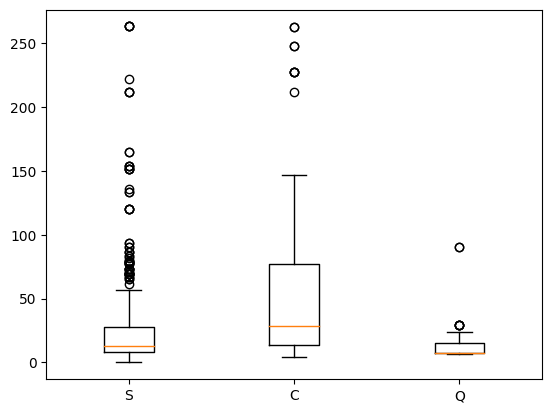

In [21]:
displ_emb_df = train[train['Embarked'].notna()]
# from graphing before we see there is a very large outlier with a Fare of above 500 for simplicity sake we will remove this from the training set
displ_emb_df.drop(displ_emb_df[displ_emb_df['Fare'] > 500].index, inplace=True)

emb_labels = []
emb_fares = []
for emb_var in displ_emb_df['Embarked'].unique():
    emb_labels.append(emb_var)
    emb_fare = displ_emb_df[displ_emb_df['Embarked']==emb_var]['Fare']
    emb_fares.append(emb_fare)
    
fig, ax = plt.subplots()
ax.boxplot(emb_fares, labels=emb_labels)
plt.show()

From the boxplots above there appears to be a clear ordering in Fare between the 3 embarked categories.

Observing the boxplots it seems that Q has the lowest median line, smallest IQR, and the lowest in general Fare values. S comes in second and C comes in last with the highest Fares.

To impute the missing Embarked values we will grab the rows with the missing embarked values and map their embarked value to whichever fare distribution it matches the closest to. 

In [22]:
# all of the rows in train where Embarked is NaN
empty_embarked_df = train[train['Embarked'].isna()]

#for each of the Embarked values get the median values of its numeric values
emb_medians = train.groupby('Embarked').median(numeric_only=True).reset_index()

# for each of the empty Embarked rows 
for i in range(len(empty_embarked_df)):
    empty_row = empty_embarked_df.iloc[i]
    min_dist = 999
    closest_emb = None
    # find the median Fare value the empty rows Fare is closest to
    for j in range(len(emb_medians)):
        emb_med_row = emb_medians.iloc[j]
        emb_med_fare = emb_med_row['Fare']
        dist = abs(emb_med_fare - empty_row['Fare'])
        if dist < min_dist:
            min_dist = dist
            closest_emb = emb_med_row['Embarked']
    # find the row in the training set and assign its embarked value to the found closest embarked value
    empty_idx = train.index[train['PassengerId'] == empty_row['PassengerId']][0]
    train.at[empty_idx, 'Embarked'] = closest_emb
    

In [23]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         0
dtype: int64

We can choose either way but I will assign a cardinal ordering of 1 to C, 2 to S, and 3 to Q. 
Meaning there should be a negative correlation now between Fare and Embarked. (The higher the Fare the lower the expected Embarked value)

In [24]:
train['Embarked'] = train['Embarked'].map({
    "C": 1,
    "S": 2,
    "Q": 3
})

# Trying different method of assigning binary categorical values to embarked to see if get increased lr performance
# from sklearn.preprocessing import OneHotEncoder

# encoder = OneHotEncoder(handle_unknown='ignore')

# #perform one-hot encoding on 'team' column 
# encoded_embarked = pd.DataFrame(encoder.fit_transform(train[['Embarked']]).toarray())

# #merge one-hot encoded columns back with original DataFrame
# train = train.join(encoded_embarked)
# train = train.drop(columns=['Embarked'])
# train.head()

#### 2.3 Age <a class="anchor" id="2.3"></a>

There are many ways to fill in Age, the simplest is to fill in the missing values with the mean of all ages. However, we can get a more accurate guess on a missing age value if we use Linear regression. 

Another way is to use other features to help indicate a range of what the age might be. A popular method noticed in other Titanic Notebooks is to create an age range for the titles that passangers share. Like Mr, Mrs, Miss, Master, etc... 

Mrs maps to married women and it is known that their age will most likely be higher than unmarried women who are almost always younger. The same goes for Mr. and Master. Master is used to refer to young men or boys whereas Mr. refers to a Man. 

We can see which of the three methods is a better indicator of age based on which gives us a better prediction score on our base model.

In [25]:
# Age_w_Means stands for Age with means (missing values replaced with mean age)
train['Age_w_Means'] = train['Age'].fillna(train['Age'].mean())

In [26]:
train['Title'] = train['Name'].str.split(', ').str[1].str.split('.').str[0]

In [27]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_w_Means,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,2,22.0,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,1,38.0,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,2,26.0,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,2,35.0,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,2,35.0,Mr


For the last age imputation attempt we will be mapping the titles from each name to an age range and replacing the missing age values with their title mean. 

Also, since we cannot use our Name column for the age linear regression portion we can grab the titles from it and assign them numeric values to help train our age lr imputation.

In [28]:
train[~train['Age'].isna()].groupby('Title')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Title,,,,,,,,
Capt,1.0,70.000000,NaN,70.00,70.000,70.0,70.00,70.0
Col,2.0,58.000000,2.828427,56.00,57.000,58.0,59.00,60.0
Don,1.0,40.000000,NaN,40.00,40.000,40.0,40.00,40.0
Dr,6.0,42.000000,12.016655,23.00,35.000,46.5,49.75,54.0
Jonkheer,1.0,38.000000,NaN,38.00,38.000,38.0,38.00,38.0
Lady,1.0,48.000000,NaN,48.00,48.000,48.0,48.00,48.0
Major,2.0,48.500000,4.949747,45.00,46.750,48.5,50.25,52.0
Master,36.0,4.574167,3.619872,0.42,1.000,3.5,8.00,12.0
Miss,146.0,21.773973,12.990292,0.75,14.125,21.0,30.00,63.0


Don is a title for men in Spanish, Major is a military title for a man, Sir is another title for a man, Jonkheer is a title for men in the nobility in netherlands, and Rev is short for Reverend which is a title for a catholic priest to which it is known that catholic priests are only men. 
Therefore all of these mentioned titles will be mapped to Mr.

Lady is another term for Countess, which both refer to a women (the title is mostly obtained by marying into a noble) therefore these will be mapped to Mrs.

Mlle, Mme, and Miss all refer to an unmarried women. Therefore they will be mapped to the Ms title.

Master refers to younger men or boys therefore it will be its own category.

The remaining titles Capt, Col, Dr are all senior titles that are acheived after some time therefore their average ages will be slightly higher than their associated generic gender titles so we will map them to a Senor title.

Therefore the mappings are:

Don, Sir, Jonkheer, Rev -> Mr.

Lady, Countess -> Mrs.

Mlle, Miss, Mlle, Mme -> Ms.

Master -> Master

Capt, Major, Col, Dr -> Senor

In [29]:
train['Mr'] = train.Title.apply(lambda x: 1 if x in ['Mr', 'Don', 'Sir', 'Jonkheer', 'Rev'] else 0)
train['Mrs'] = train.Title.apply(lambda x: 1 if x in ['Mrs', 'Lady', 'Countess', 'the Countess'] else 0)
train['Ms'] = train.Title.apply(lambda x: 1 if x in ['Ms', 'Miss', 'Mlle', 'Mme'] else 0)
train['Master'] = train.Title.apply(lambda x: 1 if x == 'Master' else 0)
train['Senor'] = train.Title.apply(lambda x: 1 if x in ['Capt', 'Major', 'Col', 'Dr'] else 0)

In [30]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_w_Means,Title,Mr,Mrs,Ms,Master,Senor
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0,2,22.0,Mr,1,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1,1,38.0,Mrs,0,1,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0,2,26.0,Miss,0,0,1,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1,2,35.0,Mrs,0,1,0,0,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0,2,35.0,Mr,1,0,0,0,0


In [31]:
for i, a in enumerate(train['Age']):
    if pd.isna(a):
        train.loc[i, 'Age_w_TitleMed'] = train[train['Title'] == train.loc[i, 'Title']]['Age'].median()
    else:
        train.loc[i, 'Age_w_TitleMed'] = train.loc[i, 'Age']

In [32]:
linr = LinearRegression()

LR_train = train.drop(columns=['Ticket', 'Name', 'Embarked', 'Title', 'Age_w_Means', 'Age_w_TitleMed'])
#Assigning binary values to male and female
LR_train['Sex'] = (LR_train['Sex'] == 'male').astype(int)


train_age = LR_train.loc[LR_train['Age'].notnull()]
train_age_x = train_age.loc[:, train_age.columns != 'Age']
train_age_y = train_age['Age']

test_age = LR_train.loc[LR_train['Age'].isna()]
test_age_x = test_age.loc[:, test_age.columns != 'Age']

linr.fit(train_age_x, train_age_y)

predict = linr.predict(test_age_x)


pred_idx = 0
for i in range(len(train)):
    #fill in the missing value with its associated LR predicted value
    if pd.isna(train.loc[train.index[i], 'Age']):
        train.loc[train.index[i], 'Age_w_LR'] = max(1, predict[pred_idx]) # overwrite the prediction of age values less than 1
        pred_idx += 1
    #otherwise fill in the cell with its Age value
    else:
        train.loc[train.index[i], 'Age_w_LR'] = train.loc[train.index[i], 'Age']


In [33]:
#drop name and title column and map sex column to binary so we can test which Age column gives us the best performance
test_train = train.drop(['Name', 'Ticket', 'Title', 'Mr', 'Mrs', 'Ms', 'Master', 'Senor'], axis=1) 
test_train['Sex'] = (test_train['Sex'] == 'male').astype(int)

In [34]:
test_train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Age_w_Means,Age_w_TitleMed,Age_w_LR
0,1,0,3,1,22.0,1,0,7.2500,0,2,22.0,22.0,22.0
1,2,1,1,0,38.0,1,0,71.2833,1,1,38.0,38.0,38.0
2,3,1,3,0,26.0,0,0,7.9250,0,2,26.0,26.0,26.0
3,4,1,1,0,35.0,1,0,53.1000,1,2,35.0,35.0,35.0
4,5,0,3,1,35.0,0,0,8.0500,0,2,35.0,35.0,35.0


Now that we have added 3 seperate methods in the form of filling missing age values we can test to see which gets the best performance using a benchmark random forrest tree using cross validation to split the training set into a train-test set.

In [35]:
def score_test(x, y):
    rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=123)
    logistic_model = LogisticRegression(max_iter=2000)
    rf_score = cross_val_score(rf_model, x, y, scoring="accuracy").mean()
    logistic_score = cross_val_score(logistic_model, x, y, scoring="accuracy").mean()
    return {'Random Forest': rf_score, 'Logistic Regression': logistic_score}

In [36]:
age_means = test_train.drop(['Age', 'Age_w_LR', 'Age_w_TitleMed'], axis=1)
age_lr = test_train.drop(['Age', 'Age_w_Means', 'Age_w_TitleMed'], axis=1)
age_TMed = test_train.drop(['Age', 'Age_w_Means', 'Age_w_LR'], axis=1)

In [37]:
age_means_x = age_means.loc[:, age_means.columns != 'Survived']
age_means_y = age_means['Survived']
age_means_score = score_test(age_means_x, age_means_y)

age_lr_x = age_lr.loc[:, age_lr.columns != 'Survived']
age_lr_y = age_lr['Survived']
age_lr_score = score_test(age_lr_x, age_lr_y)

age_TMed_x = age_TMed.loc[:, age_TMed.columns != 'Survived']
age_TMed_y = age_TMed['Survived']
age_TMed_score = score_test(age_TMed_x, age_TMed_y)

print('age_means_score:', age_means_score)
print('age_lr_score:', age_lr_score)
print('age_TMed_score:', age_TMed_score)

age_means_score: {'Random Forest': 0.8047831272362063, 'Logistic Regression': 0.7867491055175444}
age_lr_score: {'Random Forest': 0.8305881614462368, 'Logistic Regression': 0.8035967610319503}
age_TMed_score: {'Random Forest': 0.8059192768815517, 'Logistic Regression': 0.7923545289059067}


Without using binary title columns to train the age lr imputation:

age_means_score: {'Random Forest': 0.8047831272362063, 'Logistic Regression': 0.7867491055175444} <br>
age_lr_score: {'Random Forest': 0.8272048207896555, 'Logistic Regression': 0.8024794425961961} <br>
age_TMed_score: {'Random Forest': 0.8059192768815517, 'Logistic Regression': 0.7923545289059067} <br>

Without dropping binary title columns for test_train:

age_means_score: {'Random Forest': 0.8148578243675854, 'Logistic Regression': 0.8204004770573097} <br>
age_lr_score: {'Random Forest': 0.819327098110602, 'Logistic Regression': 0.8338773460548616} <br>
age_TMed_score: {'Random Forest': 0.814864101437449, 'Logistic Regression': 0.8271294959512898} <br>

After dropping binary title columns for test_train:

age_means_score: {'Random Forest': 0.8047831272362063, 'Logistic Regression': 0.7834034272801457} <br>
age_lr_score: {'Random Forest': 0.8294645659406189, 'Logistic Regression': 0.8024731655263324} <br>
age_TMed_score: {'Random Forest': 0.8059192768815517, 'Logistic Regression': 0.7912309334002887} <br>

After attempting many differenct random states, switching from age title median to Age title mean. Imputting missing age values with Linear regression consistently beats out the other methods in terms of random forrest and logistic regression in accuracy score. Thus we will remove the other two column and rename age_w_LR to just Age.

In [38]:
train = train.drop(['Age', 'Age_w_Means', 'Age_w_TitleMed'], axis=1)
train.rename(columns = {'Age_w_LR':'Age'}, inplace = True)

In [39]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Mr,Mrs,Ms,Master,Senor,Age
0,1,0,3,"Braund, Mr. Owen Harris",male,1,0,A/5 21171,7.2500,0,2,Mr,1,0,0,0,0,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,1,0,PC 17599,71.2833,1,1,Mrs,0,1,0,0,0,38.0
2,3,1,3,"Heikkinen, Miss. Laina",female,0,0,STON/O2. 3101282,7.9250,0,2,Miss,0,0,1,0,0,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,1,0,113803,53.1000,1,2,Mrs,0,1,0,0,0,35.0
4,5,0,3,"Allen, Mr. William Henry",male,0,0,373450,8.0500,0,2,Mr,1,0,0,0,0,35.0


In [40]:
train.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
Title          0
Mr             0
Mrs            0
Ms             0
Master         0
Senor          0
Age            0
dtype: int64

We have now successfully imputed all missing values and can now move onto feature engineering.

## 3. Feature Engineering <a class="anchor" id="feature-eng"></a>

First should plot Mutual information scores to measure linear and non linear relationships between the features and the prediction target to see which features are valuable to select and extend upon.

Mutual information will measure how the change in each categorical variable affects the change in the survived value. Basically, it will capture any type of relationship between the categorical features and the label not only a linear relationship like a correlation heatmap would.

In [41]:
#Assigning binary values to male and female
train['Sex'] = (train['Sex'] == 'male').astype(int)

Text(0.5, 1.0, 'Mutual information between numerical columns and Survived')

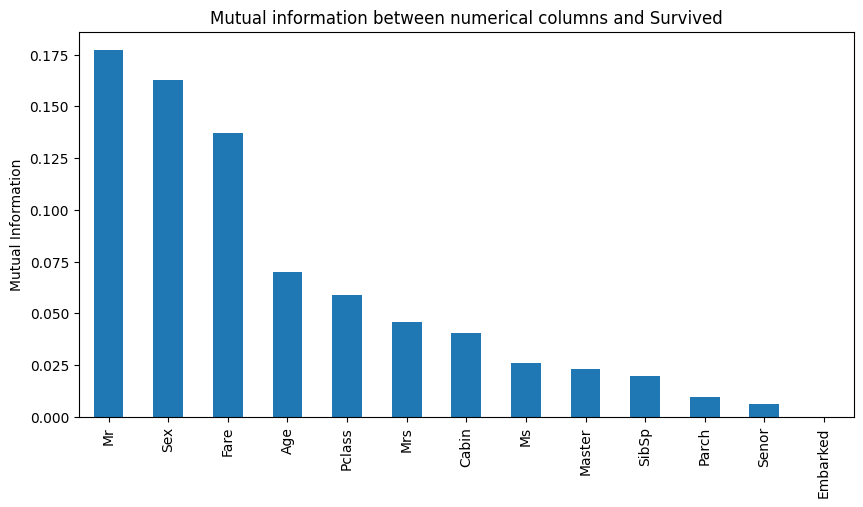

In [42]:
from sklearn.feature_selection import mutual_info_classif

numerical_columns = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Cabin', 'Embarked', 'Mr', 'Mrs', 'Ms', 'Master', 'Senor', 'Fare', 'Age']

x_train_mi = train[numerical_columns]
y_train_mi = train['Survived']
mi = mutual_info_classif(x_train_mi, y_train_mi)
mi_series = pd.Series(mi)
mi_series.index = x_train_mi.columns
mi_series.sort_values(ascending=False).plot.bar(figsize=(10, 5))
plt.ylabel('Mutual Information')
plt.title("Mutual information between numerical columns and Survived")


Given that our highest mutual info column is the Mr feature we created we can see that a combination of sex and age range has the biggest impact on Survival.

From this we can seek out to find the most impactful combinations of Age and gender.

/var/folders/y6/161nhsl11ys797vxqdv0p8m40000gq/T/ipykernel_97965/648726730.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(train.corr(),cbar=True,annot=True,cmap='Blues')


<Axes: >

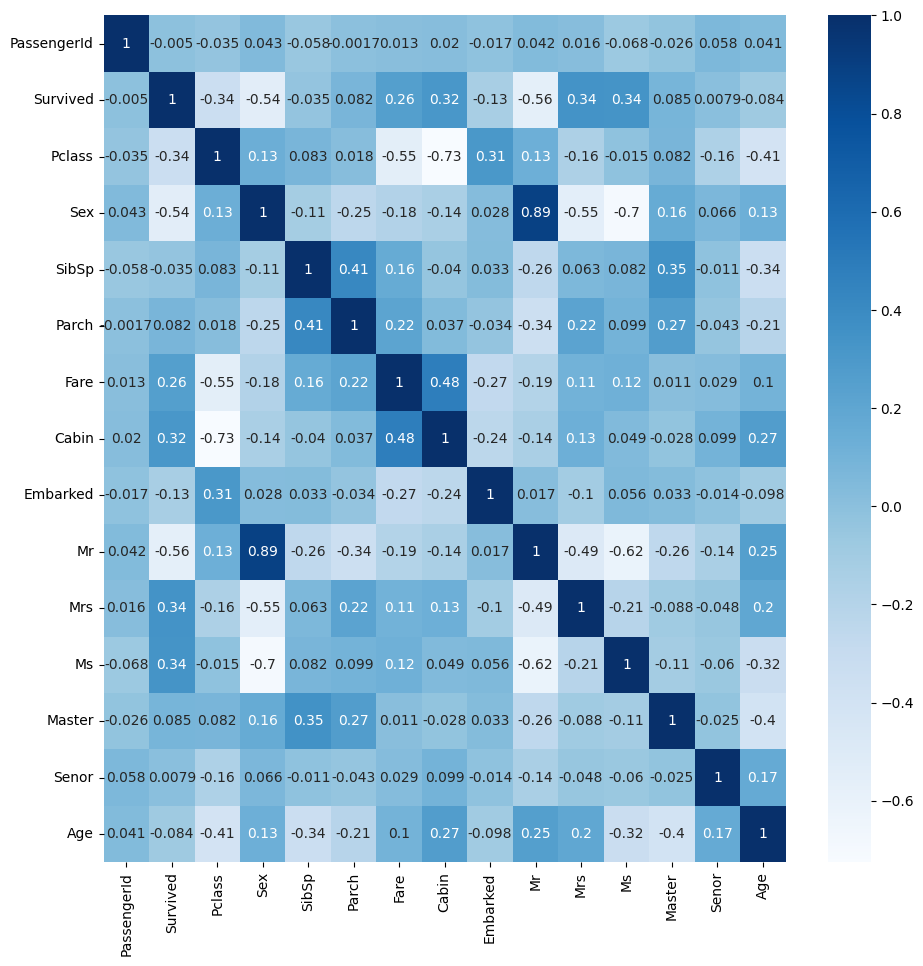

In [43]:
plt.figure(figsize=(11,11))
sns.heatmap(train.corr(),cbar=True,annot=True,cmap='Blues')

#### 3.1 Sex and Age <a class="anchor" id="3.1"></a>

Since the one hot Titles are bins of sex and age combined we will try those vs just sex and age and see which gives us the better score then choose that.

In [44]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Mr,Mrs,Ms,Master,Senor,Age
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,7.2500,0,2,Mr,1,0,0,0,0,22.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,71.2833,1,1,Mrs,0,1,0,0,0,38.0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,7.9250,0,2,Miss,0,0,1,0,0,26.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,53.1000,1,2,Mrs,0,1,0,0,0,35.0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,8.0500,0,2,Mr,1,0,0,0,0,35.0


In [45]:
model_w_titles = train.drop(['Name', 'Ticket', 'Title', 'Sex', 'Age'], axis=1)

model_w_sex_age = train.drop(['Name', 'Ticket', 'Title', 'Mr', 'Mrs', 'Ms', 'Master', 'Senor'], axis=1)

model_w_titles_x = model_w_titles.loc[:, model_w_titles.columns != 'Survived']
model_w_titles_y = model_w_titles['Survived']
model_w_titles_score = score_test(model_w_titles_x, model_w_titles_y)

model_w_sex_age_x = model_w_sex_age.loc[:, model_w_sex_age.columns != 'Survived']
model_w_sex_age_y = model_w_sex_age['Survived']
model_w_sex_age_score = score_test(model_w_sex_age_x, model_w_sex_age_y)


print('model_w_titles_score:', model_w_titles_score)
print('model_w_sex_age:', model_w_sex_age_score)

model_w_titles_score: {'Random Forest': 0.8237963718536188, 'Logistic Regression': 0.8215366267026551}
model_w_sex_age: {'Random Forest': 0.8305881614462368, 'Logistic Regression': 0.8035967610319503}


Given that the model using sex and age returned the highest score (using Random Forest) we will drop the titles and use sex and age instead.

In [46]:
train = train.drop(['Name', 'Ticket', 'Title', 'Mr', 'Mrs', 'Ms', 'Master', 'Senor'], axis=1)

In [47]:
train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked,Age
0,1,0,3,1,1,0,7.2500,0,2,22.0
1,2,1,1,0,1,0,71.2833,1,1,38.0
2,3,1,3,0,0,0,7.9250,0,2,26.0
3,4,1,1,0,1,0,53.1000,1,2,35.0
4,5,0,3,1,0,0,8.0500,0,2,35.0


#### 3.2 SibSp <a class="anchor" id="3.2"></a>

7


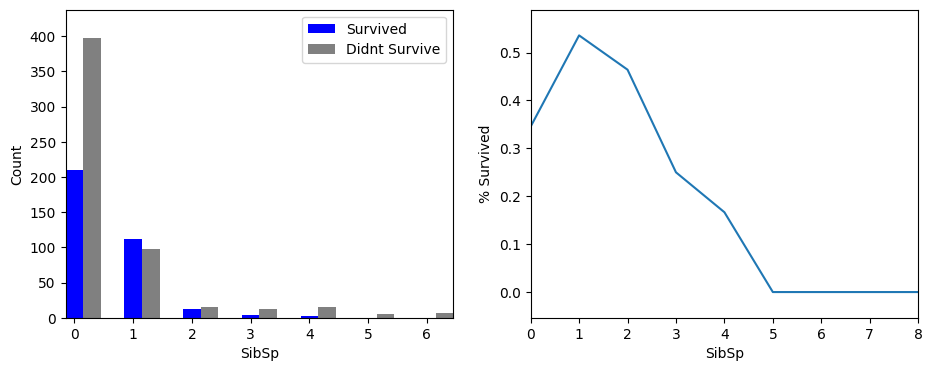

In [48]:
#SibSp - number of siblings/spouses on board
SibSp_nunique = train['SibSp'].nunique()
print(SibSp_nunique)
# Since there is only  unique values we can display the survived for each value and see how we can bin these values
# Plotting a bar plot of the count but seperating them into survived and did not survive should give us a visual idea of the total count and the % split of survival

# #https://towardsdatascience.com/a-beginners-guide-to-kaggle-s-titanic-problem-3193cb56f6ca#:~:text=Embarked%20implies%20where%20the%20traveler,the%20rest%20boarded%20from%20Queenstown.
# #https://medium.com/the-owl/plotting-grouped-bar-chart-in-matplotlib-7700e818344f



features = ['SibSp']*SibSp_nunique
sibsp_unique = train['SibSp'].unique()
sibsp_unique.sort()
feature_filters = sibsp_unique
use_filt = True
surv_ratio_graph(train, features, feature_filters, use_filt, 'SibSp')
   

Looking at the plots above the % ratio for survived seems to simulate a poisson distribution. It would seem that the optimal amount of siblings/spouses to have on board with you to increase your survival rate is 1-2. However, given that the count for values of 1 or greater is much less than that of passengers with a SibSp of zero it cannot be assumed that the survival ratio for SibSp of 1 or greater is an accurate representation of the population. 
*Look into central limit theorem for this*
Due to the non-normal distribution, we can sample 10% of the training set to try and get a normal distribution to see what the % of survived is really like for SibSp

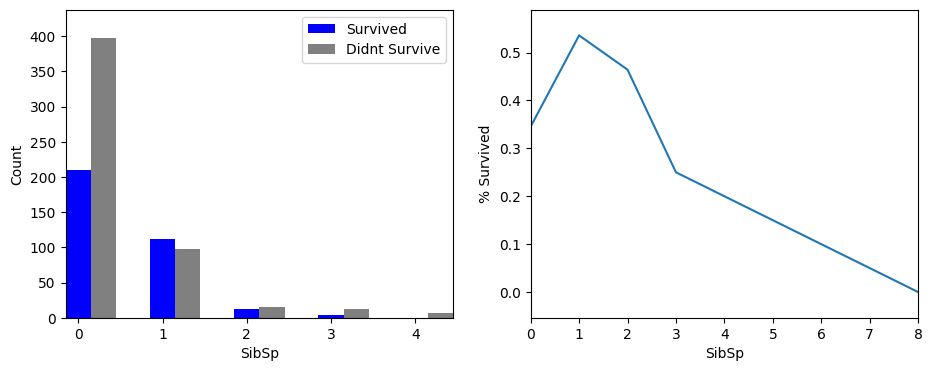

In [49]:
#randomly sample 10% of the training set
sample_train = train.sample(frac=0.1, replace=True)
SibSp_nunique = sample_train['SibSp'].nunique()
features = ['SibSp']*SibSp_nunique
sibsp_unique = sample_train['SibSp'].unique()
sibsp_unique.sort()
feature_filters = sibsp_unique
use_filt = True

print('')

surv_ratio_graph(sample_train, features, feature_filters, use_filt, 'SibSp')


We will be splitting sibsp into 3 categorical variables: 0, 1, and 2+ Sibsp then getting the observed and expected survival count for each and performing a chi sq test to see if it is worth splitting Sibsp into bins.

In [50]:
# train['0_Sibsp'] = train.Sibsp.apply(lambda x: 1 if x == 0 else 0)
# train['1_SibSp'] = train.Sibsp.apply(lambda x: 1 if x == 1 else 0)
# train['2+_Sibsp'] = train.SibSp.apply(lambda x: 1 if x > 1 else 0)

zero_SibSp = len(train[train['Sibsp']==0])
one_SibSp = len(train[train['Sibsp']==1])
twoPlus_Sibsp = len(train[train['Sibsp']>1])



KeyError: 'Sibsp'

7


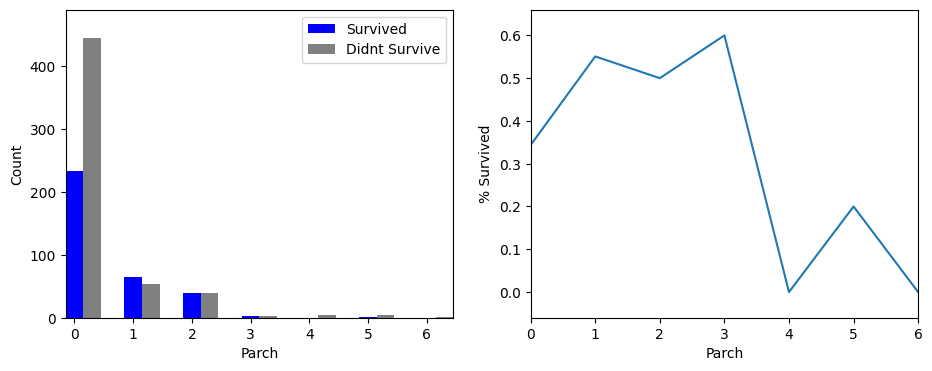

In [51]:
#Parch - Number of Parents/Children Aboard
parch_nunique = train['Parch'].nunique()
print(parch_nunique)
# Since there is only  unique values we can display the survived for each value and see how we can bin these values
# Plotting a bar plot of the count but seperating them into survived and did not survive should give us a visual idea of the total count and the % split of survival


features = ['Parch']*parch_nunique
parch_unique = train['Parch'].unique()
parch_unique.sort()
feature_filters = parch_unique
use_filt = True

surv_ratio_graph(train, features, feature_filters, use_filt, 'Parch')

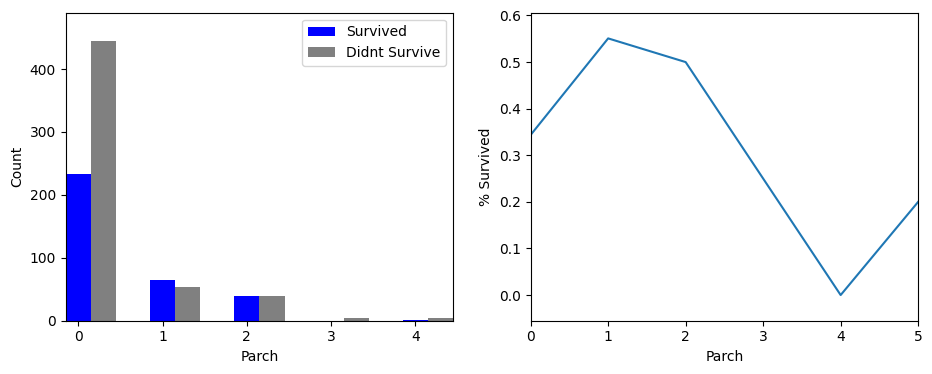

In [52]:
#randomly sample 10% of the training set
sample_train = train.sample(frac=0.1, replace=True)
parch_nunique = sample_train['Parch'].nunique()
features = ['Parch']*parch_nunique
parch_unique = sample_train['Parch'].unique()
parch_unique.sort()
feature_filters = parch_unique
use_filt = True

surv_ratio_graph(sample_train, features, feature_filters, use_filt, 'Parch')

Attemping to split Parch into 0, 1, and 2+ bins to see which has more impact
also attemping 0 and 1+ bins
check with chi square and evaluate different performances

In [54]:
train['Parch_0'] = train.Parch.apply(lambda x: 1 if x == 0 else 0)
train['Parch_1'] = train.Parch.apply(lambda x: 1 if x == 1 else 0)
train['Parch_2+'] = train.Parch.apply(lambda x: 1 if x >= 2 else 0)

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Cabin,Embarked,Age,Parch_0,Parch_1,Parch_2+
0,1,0,3,1,1,0,7.2500,0,2,22.0,1,0,0
1,2,1,1,0,1,0,71.2833,1,1,38.0,1,0,0
2,3,1,3,0,0,0,7.9250,0,2,26.0,1,0,0
3,4,1,1,0,1,0,53.1000,1,2,35.0,1,0,0
4,5,0,3,1,0,0,8.0500,0,2,35.0,1,0,0


In [153]:
test_x.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [154]:
train_x = train.loc[:, train.columns != "Survived"]
train_y = train["Survived"]
test_x = test_x.drop(columns=['Name', 'Ticket'])
test_x['Cabin'] = test_x['Cabin'].where(test_x['Cabin'].isnull(), 1).fillna(0).astype(int)
test_x['Sex'] = (test_x['Sex'] == 'male').astype(int)
test_x['Age'] = test_x['Age'].fillna(test_x['Age'].mean())
test_x['Fare'] = test_x['Fare'].fillna(test_x['Fare'].mean())
test_x['Embarked'] = test_x['Embarked'].map({
    "C": 1,
    "S": 2,
    "Q": 3
})

test_y = test["Survived"]

test_x.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [155]:
# From the Fare boxplots it can be observed that having a larger Fare had a significant impact on Surviving
# Firstly from the fact that the median line for Survived has a larger Fare value
# Second from the fact that the IQR for Survived reaches to a much higher Fare value 
# The median line for Survived is at about the same Fare value as Q3 for the Didnt Survive boxplot. This means that more than 50% of the people that survived had a higher Fare value than 75% of the people that didnt survive
# Another noticable point in the graph is that any point above a Fare of around 50 is considered as an outlier for Didnt Survive. This is significant evidence that those with a higher fare value are statistically supposed to survive and it is seen as an outlier in the dataset if they dont

# I would like to observe how dependent pclass and cabin are on Fare to see if pclass and/or cabin provide any extra information (or impact on survived) that fare doesnt
# Not sure exactly how to statistically test for this but for now I will do two logistic regression models one with cabin and one without cabin
# I will perform a couple of random attempts to see if there is a significant difference in performance between the two


from sklearn.linear_model import LogisticRegression

logir = LogisticRegression(max_iter=1000)

logir.fit(train_x, train_y)

train_predictions = logir.predict(train_x)
test_predictions = logir.predict(test_x)

train_score = logir.score(train_x, train_y)
test_score = logir.score(test_x, test_y)

print(train_score)
print(test_score)

#embarked w/ cardinal got train: 80.5%, test: 93.7%
# when embarked replaced with 3 columns each with binary 0 or 1 value for if has this embarked type train: 80.5%, test: 36.6%
# age.fillna with age.mean() replaced with linear regression on age get train: 81.8%, test: 91.6%
# strange that test score is better than training score when lr model is trained/fit on the training set


0.8069977426636569
0.9401913875598086
